In [1]:
%matplotlib inline
import time
import matplotlib.pyplot as plt
import numpy as np
import pickle
import os
from keras.datasets import cifar10
import torch

/usr0/home/cjyeh/anaconda/envs/py3/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
num_classes = 10 #    
(x_train, y_train), (x_test, y_test) = cifar10.load_data() 
# x_train - training data(images), y_train - labels(digits)

with open("../output/weight_matrix_Cifar.pkl", "rb") as input_file:
    [weight_matrix,y_predict] = pickle.load(input_file)
    
output_test = pickle.load(open('../data/output_test_cifar.pkl', 'rb'))
output_test_labels = np.argmax(output_test, axis=1)
output_train_labels = np.argmax(y_predict, axis=1)

with open('../data/intermediate34_train.pkl' , 'rb') as f:
    train_output34 = pickle.load(f)
    
with open('../data/intermediate34_test.pkl', 'rb') as f:
    test_output34 = pickle.load(f)
    
with open('../data/intermediate36_train.pkl' , 'rb') as f:
    train_output36 = pickle.load(f)
    
with open('../data/intermediate36_test.pkl', 'rb') as f:
    test_output36 = pickle.load(f)
    
with open('../data/presoft_test.pkl', 'rb') as f:
    presoft_test = pickle.load(f)

# Load influence functions 
# this contains the results for the first 1000 test points
f = np.load('../output/cifar_inf_test_1000.npz')
inf = f['influences']

In [3]:
# sort the weight matrix for each target class
top_orders = dict()
for k in range(num_classes):
    idx = np.flip(np.argsort(weight_matrix[:,k]), axis=0)
    top_orders[k] = idx
    
top_abs_orders = dict()
for k in range(num_classes):
    idx = np.flip(np.argsort(np.abs(weight_matrix[:,k])), axis=0)
    top_abs_orders[k] = idx

# influence order
inf_idx = np.flip(np.argsort(inf, axis=0), axis=0)
inf_abs_idx = np.flip(np.argsort(np.abs(inf), axis=0), axis=0)

In [4]:
### Compute the distribution using each method. 
tensor_train34 = torch.FloatTensor(train_output34)
tensor_test34 = torch.FloatTensor(test_output34)
w_tensor = torch.FloatTensor(weight_matrix)

prod = torch.matmul(tensor_train34,torch.t(tensor_test34))
dd = y_test.flatten()
one_hot = np.eye(10)[dd]
one_hot_tensor = torch.FloatTensor(one_hot)
prod2 = torch.matmul(w_tensor, torch.t(one_hot_tensor))

inf_ours = torch.mul(prod, prod2)[:, :1000]
inf_ours = inf_ours.cpu().numpy()

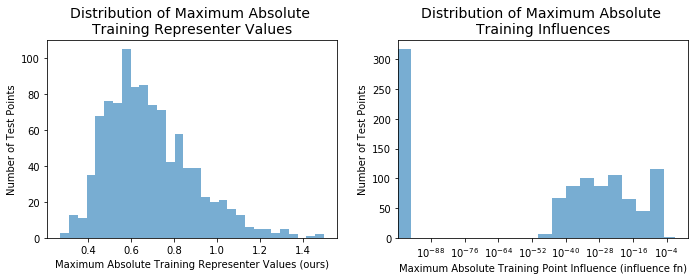

In [5]:
## Plot the distribution for both methods. Plot the maximum training point influence.
f, axs = plt.subplots(1,2, figsize=(10, 4))
ours_hist = axs[0].hist(np.max(np.abs(inf_ours), axis=0), bins=30, label='ours', alpha=0.6)
#axs[0].set_yscale('log')
#plt.xscale('log')
axs[0].set_xlabel('Maximum Absolute Training Representer Values (ours)')
axs[0].set_ylabel('Number of Test Points')
axs[0].set_title('Distribution of Maximum Absolute \nTraining Representer Values', fontsize=14)

bins = [0.0, 1e-95, 1e-50, 1e-45, 1e-40, 1e-35, 1e-30, 1e-25, 1e-20, 1e-15, 1e-10, 1e-5, 1e-1]
inf_hist = axs[1].hist(np.max(np.abs(inf), axis=0), bins=bins, label='influence fn', alpha=0.6)
axs[1].set_xscale('log')
axs[1].set_xlabel('Maximum Absolute Training Point Influence (influence fn)')
axs[1].set_ylabel('Number of Test Points')
axs[1].set_title('Distribution of Maximum Absolute \nTraining Influences', fontsize=14)
plt.tight_layout()
plt.savefig('inf_distribution.png', dpi=200)